Text(0,0.5,'O-C [min]')

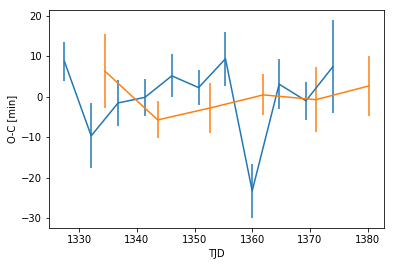

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

b_times = np.load('transit_times_b.npy')[0, :]
b_uncertainties = np.load('transit_times_b.npy')[1, :]
b_epoch = np.arange(len(b_times))

c_times = np.load('transit_times_c.npy')[0, :]
c_uncertainties = np.load('transit_times_c.npy')[1, :]
c_epoch = np.arange(len(c_times))

plt.errorbar(b_times, 24*60*(b_times - np.polyval(np.polyfit(b_epoch, b_times, 1), b_epoch)), 24*60*b_uncertainties)
plt.errorbar(c_times, 24*60*(c_times - np.polyval(np.polyfit(c_epoch, c_times, 1), c_epoch)), 24*60*c_uncertainties)
plt.xlabel('TJD')
plt.ylabel('O-C [min]')

In [25]:
from ttvfast import ttvfast
from ttvfast.models import Planet 
from astropy.constants import M_sun, M_earth
import numpy as np
import astropy.units as u

period_b_init = 4.653811
period_c_init = 9.150607

mass_b_init = 1 * float(M_earth/M_sun) 
mass_c_init = 1 * float(M_earth/M_sun) 

# b
a = 12.10
b = 0.27

inclination_b = np.degrees(np.arccos(b/a))

# c
a = 25.12 
b = 0.22 

inclination_c = np.degrees(np.arccos(b/a))

# mass_b_init_err = 0.154 * float(M_earth/M_sun) 
# mass_c_init_err = 0.142 * float(M_earth/M_sun) 

In [42]:
phase = 360 * (((b_times.min() - c_times.min())/period_c_init) % 1 )

b = Planet(mass=mass_b_init, period=period_b_init, eccentricity=0, inclination=inclination_b, 
           longnode=0, argument=90, mean_anomaly=0)
c = Planet(mass=mass_c_init, period=period_c_init, eccentricity=0, inclination=inclination_c, 
           longnode=0, argument=90, mean_anomaly=phase)
result = ttvfast(planets=[b, c], stellar_mass=0.90, time=b_times.min(), dt=period_b_init/100, total=b_times.min()+1000)
planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
condition = (times != -2)
planet_ind, epoch, times, rsky, vsky = [i[condition] for i in [planet_ind, epoch, times, rsky, vsky]]

indices_b = (planet_ind == 0) & np.in1d(epoch, b_epoch)
indices_c = (planet_ind == 1) & np.in1d(epoch, c_epoch)
epoch_c = epoch[indices_c]
model_times_b = times[indices_b]
model_times_c = times[indices_c]

# logchi2_e = -0.5 * np.sum( (model_times_e - times_e)**2 / errs_e**2 )
# logchi2_f = -0.5 * np.sum( (model_times_f - times_f)**2 / errs_f**2 )

model_times_b - b_times, model_times_c - c_times

(array([ 4.79758455e-11,  1.23326166e-02,  6.23462004e-03,  4.85001985e-03,
         6.98613973e-04,  2.28881010e-03, -3.12019080e-03,  1.91053325e-02,
         3.38432435e-04,  2.76547622e-03, -3.55388171e-03]),
 array([-0.00014804,  0.00955562,  0.00884646,  0.00797411,  0.0101501 ,
         0.00916068]))

In [51]:
import emcee
from corner import corner

from astropy.constants import G, M_sun
M_starM_sun = 1.0
M_star = M_starM_sun * M_sun
a_b = ( ( (G * M_star)/(4 * np.pi**2) * (period_b_init*u.day)**2 )**(1/3) ).decompose()
a_c = ( ( (G * M_star)/(4 * np.pi**2) * (period_c_init*u.day)**2 )**(1/3) ).decompose()

def lnprob(p):
    mass_b, mass_c, period_b, period_c, lam_b, lam_c, w_b, w_c = p

    if (mass_b < 0 or mass_c < 0 or mass_b > 1e-5 or mass_c > 1e-5):# or 
        #ecc_b < 0 or ecc_b > 0.01 or ecc_c < 0 or ecc_c > 0.01):
        return -np.inf
    
    ecc_b = 0
    ecc_c = 0
    
    # Hill stability criterion from Gladman 1993 Eqn. 21
    gamma1 = np.sqrt(1 - ecc_b**2)
    gamma2 = np.sqrt(1 - ecc_c**2)
    mu1 = mass_b * M_starM_sun
    mu2 = mass_c * M_starM_sun
    alpha = mu1 + mu2
    Delta = (a_c - a_b)/a_b
    delta = np.sqrt(1 + Delta)
    
    if (alpha**-3 * (mu1 + mu2/delta**2)*(mu1*gamma1 + mu2*gamma2*delta)**2 <= 
        1 + 3**(4/3) * (mu1 * mu2) / alpha**(4/3)):
        return -np.inf
    
    b = Planet(mass=mass_b_init, period=period_b_init, eccentricity=0, inclination=inclination_b, 
               longnode=0, argument=90, mean_anomaly=0)
    c = Planet(mass=mass_c_init, period=period_c_init, eccentricity=0, inclination=inclination_c, 
               longnode=0, argument=90, mean_anomaly=phase)
    result = ttvfast(planets=[b, c], stellar_mass=1, time=b_times.min(), dt=period_b_init/100, total=b_times.min()+1000)
    planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
    condition = (times != -2)
    planet_ind, epoch, times, rsky, vsky = [i[condition] for i in [planet_ind, epoch, times, rsky, vsky]]
    
    # Parse results for planets e and f
    indices_b = (planet_ind == 0) & np.in1d(epoch, b_epoch)
    indices_c = (planet_ind == 1) & np.in1d(epoch, c_epoch)
    epoch_b = epoch[indices_b]
    epoch_c = epoch[indices_c]
    model_times_b = times[indices_b]
    model_times_c = times[indices_c]

    # Compute chi^2 for transit times of e and f
    logchi2_b = -0.5 * np.sum( (model_times_b - b_times)**2 / b_uncertainties**2 )
    logchi2_c = -0.5 * np.sum( (model_times_c - c_times)**2 / c_uncertainties**2 )

#     print(model_times_b.shape, times_b.shape)
    
    # Add log prior for planet mass from Gaia + forecaster
#     lnprior = (-0.5 * (mass_b - mass_b_init)**2 / mass_b_init_err**2
#                -0.5 * (mass_c - mass_c_init)**2 / mass_c_init_err**2)
    return logchi2_b + logchi2_c #+ lnprior

ndim, nwalkers = 8, 16

init_masses = [mass_b_init, mass_c_init, period_b_init, period_c_init, 0, 0, 0, phase]

p0 = [init_masses + 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)
p1 = sampler.run_mcmc(p0, 10000)[0];
sampler.reset()
p2 = sampler.run_mcmc(p1, 10000);

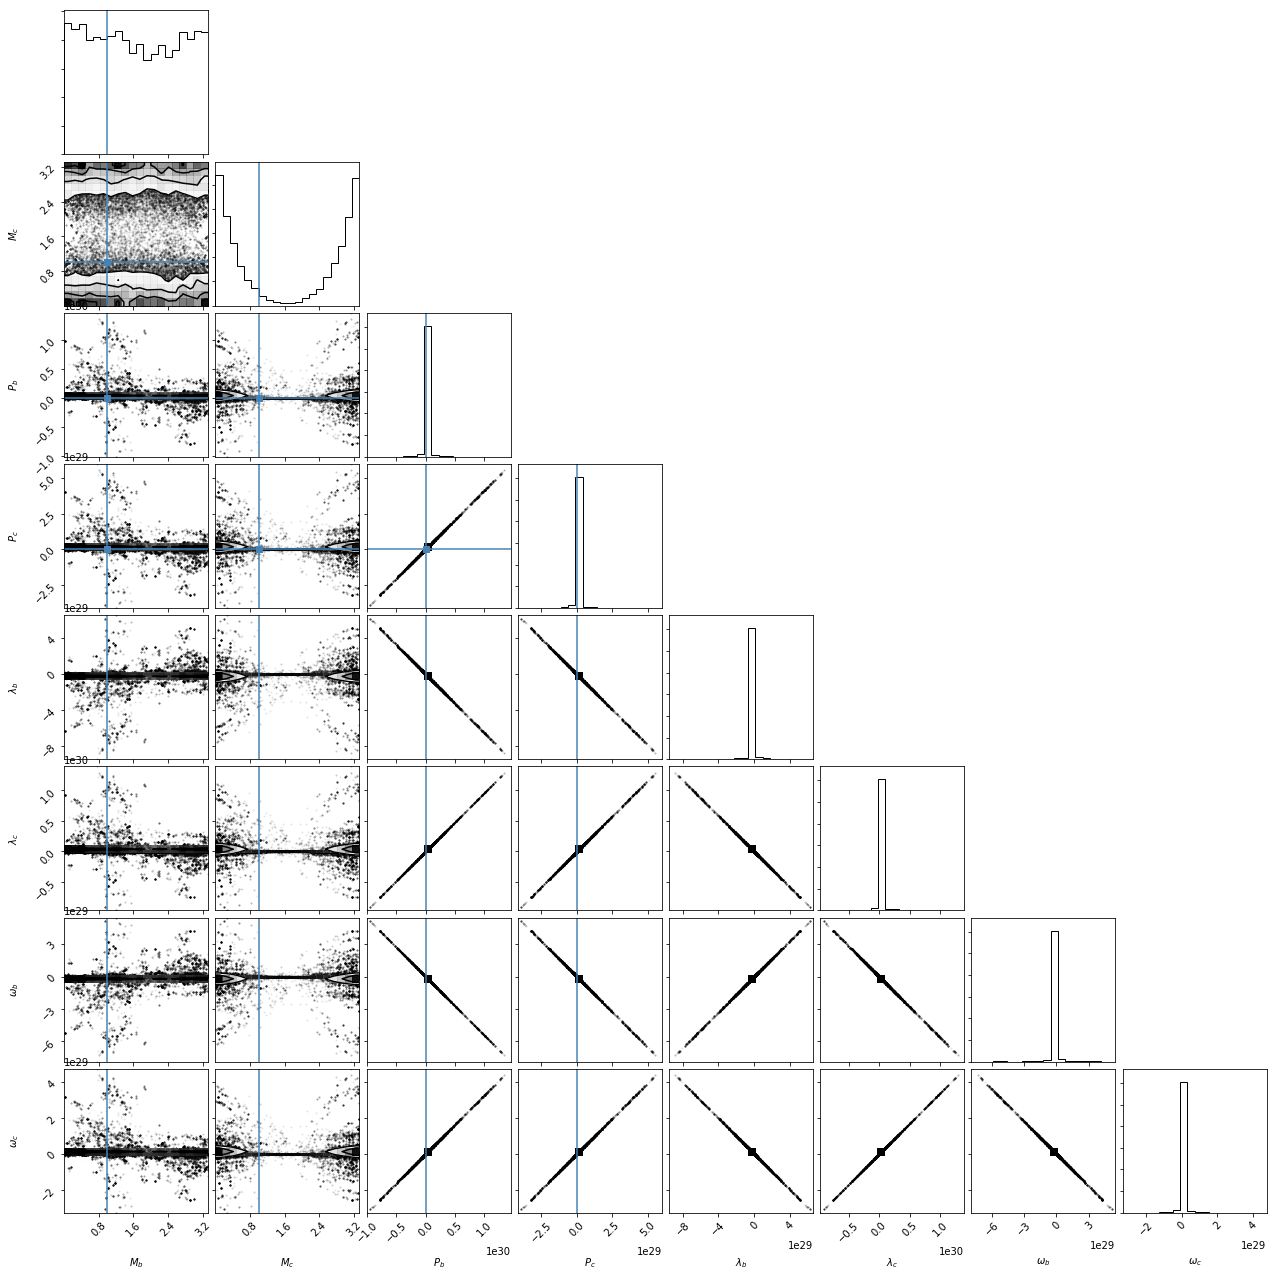

In [52]:
chains = np.copy(sampler.flatchain)
chains[:, :2] /= float(M_earth/M_sun)

corner(chains, 
       truths=[mass_b_init/float(M_earth/M_sun), mass_c_init/float(M_earth/M_sun), 
               period_b_init, period_c_init, None, None, None, None, None, None], 
       labels=['$M_b$', '$M_c$', "$P_b$", "$P_c$", '$\lambda_b$', "$\lambda_c$",
               "$\omega_b$", "$\omega_c$"]);
plt.savefig('ttv_recovery.png', bbox_inches='tight')